In [1]:
import fastf1
import os
import pandas as pd
from matplotlib import pyplot as plt
from dotenv import load_dotenv
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from fuzzywuzzy import process
import numpy as np
from datetime import timedelta

# Get the base directory path
fastf1.Cache.enable_cache('../data')  # Cache in /data

In [70]:
# --- FUNCIONES AUXILIARES TRANSCRITAS ---
def get_race_laps(year, session_name):
    if not isinstance(year, int) or year < 1950:
        raise ValueError("El año debe ser un entero válido (>=1950).")
    try:
        session = fastf1.get_session(year, session_name, 'R')
        session.load()
    except Exception as e:
        raise RuntimeError(f"Error cargando la sesión: {e}")

    laps = session.laps[["Driver", "LapTime", "Sector1Time", "Sector2Time", "Sector3Time"]].copy()
    # Eliminar filas con valores nulos o tiempos no válidos
    laps = laps.dropna(subset=["Driver", "LapTime", "Sector1Time", "Sector2Time", "Sector3Time"])
    # Opcional: filtrar solo vueltas válidas (LapTime > 0)
    laps = laps[laps["LapTime"].apply(lambda x: hasattr(x, "total_seconds") and x.total_seconds() > 0)]

    return laps.reset_index(drop=True)

def get_session_results(year: int, identifier: str, session_name: str = 'British Grand Prix'):
    if not isinstance(year, int) or year < 1950:
        raise ValueError("El año debe ser un entero válido (>=1950).")
    try:
        session = fastf1.get_session(year, session_name, identifier)
        session.load()
    except Exception as e:
        raise RuntimeError(f"Error cargando la sesión: {e}")
    
    return session.results

def is_clean_air_lap(lap, gap_threshold=3.0):
    """
    Determine if a lap is in clean air using DriverAheadTime telemetry data
    
    Args:
        lap: The lap to check
        gap_threshold: Minimum gap in seconds to be considered clean air
    
    Returns:
        bool: True if lap is in clean air
    """
    # Use DriverAheadTime from telemetry - much more accurate than time estimation
    driver_ahead_time = lap.get('DriverAheadTime', None)
    
    # If no data available, assume clean air
    if pd.isna(driver_ahead_time) or driver_ahead_time is None:
        return True
    
    # Convert to seconds if it's a timedelta
    if hasattr(driver_ahead_time, 'total_seconds'):
        gap_seconds = driver_ahead_time.total_seconds()
    else:
        gap_seconds = float(driver_ahead_time)
    
    return gap_seconds >= gap_threshold

def extract_race_pace_laps(session_laps, min_stint_length=5):
    """
    Extract race pace representative laps from FP2
    
    Args:
        session_laps: All laps from the session
        min_stint_length: Minimum number of laps in a stint to be considered
    
    Returns:
        DataFrame: Filtered laps suitable for race pace analysis
    """
    race_pace_laps = []
    
    for driver in session_laps['Driver'].unique():
        driver_laps = session_laps[session_laps['Driver'] == driver].copy()
        driver_laps = driver_laps.sort_values('LapStartTime')
        
        # Remove outliers (laps that are too slow or too fast)
        if len(driver_laps) > 0:
            lap_times = driver_laps['LapTime'].dt.total_seconds()
            q1 = np.percentile(lap_times, 25)
            q3 = np.percentile(lap_times, 75)
            iqr = q3 - q1
            lower_bound = q1 - 1.5 * iqr
            upper_bound = q3 + 1.5 * iqr
            
            driver_laps = driver_laps[
                (lap_times >= lower_bound) & 
                (lap_times <= upper_bound)
            ].copy()  # Add .copy() to avoid warnings
        
        # Group consecutive laps into stints
        driver_laps = driver_laps.copy()  # Ensure we have a copy
        driver_laps.loc[:, 'LapNumber'] = range(1, len(driver_laps) + 1)
        driver_laps.loc[:, 'TimeDiff'] = driver_laps['LapStartTime'].diff()
        driver_laps.loc[:, 'NewStint'] = driver_laps['TimeDiff'] > timedelta(minutes=5)
        driver_laps.loc[:, 'StintNumber'] = driver_laps['NewStint'].cumsum()
        
        # Filter stints with minimum length
        stint_lengths = driver_laps.groupby('StintNumber').size()
        valid_stints = stint_lengths[stint_lengths >= min_stint_length].index
        
        driver_race_laps = driver_laps[driver_laps['StintNumber'].isin(valid_stints)].copy()
        
        # Only keep laps from the middle portion of each stint (exclude first 2 and last 2 laps)
        for stint in valid_stints:
            stint_laps = driver_race_laps[driver_race_laps['StintNumber'] == stint].copy()
            if len(stint_laps) > 4:  # Need at least 5 laps to exclude first and last 2
                stint_laps = stint_laps.iloc[2:-2].copy()  # Remove first 2 and last 2 laps
                race_pace_laps.append(stint_laps)
    
    if race_pace_laps:
        return pd.concat(race_pace_laps, ignore_index=True)
    else:
        return pd.DataFrame()

def get_clean_air_race_pace(year, session_name):
    """
    Devuelve el clean air race pace en segundos para todos los pilotos en la sesión especificada.
    
    Args:
        year (int): Año de la sesión
        session_name (str): Nombre de la sesión, por ejemplo 'FP2'
    
    Returns:
        DataFrame: Race pace por piloto con columnas ['Driver', 'Laps', 'Mean', 'Median', 'Std', 'Best', 'Worst']
    """
    # Cargar la sesión
    session = fastf1.get_session(year, session_name, 'FP2')
    session.load(laps=True, telemetry=True, weather=False)
    laps = session.laps

    # Filtrar laps válidas
    valid_laps = laps[
        (laps['LapTime'].notna()) & 
        (laps['IsAccurate'] == True) &
        (~laps['TrackStatus'].isin(['4', '5', '6', '7']))  # Exclude SC, VSC, Red flag conditions
    ].copy()

    # Extract race pace laps
    race_pace_laps = extract_race_pace_laps(valid_laps)

    # Filtrar por clean air usando DriverAheadTime
    clean_air_laps = []
    for idx, lap in race_pace_laps.iterrows():
        if is_clean_air_lap(lap, gap_threshold=3.0):
            clean_air_laps.append(lap)
    if clean_air_laps:
        clean_air_df = pd.DataFrame(clean_air_laps)
        analysis_df = clean_air_df.copy()
        analysis_df.loc[:, 'LapTimeSeconds'] = analysis_df['LapTime'].dt.total_seconds()
        pace_analysis = analysis_df.groupby('Driver')['LapTimeSeconds'].agg([
            'count', 'mean', 'median', 'std', 'min', 'max'
        ]).round(3)
        pace_analysis.columns = ['Laps', 'Mean', 'Median', 'Std', 'Best', 'Worst']
        pace_analysis = pace_analysis.sort_values('Median')
        return pace_analysis.reset_index()
    else:
        return pd.DataFrame(columns=['Driver', 'Laps', 'Mean', 'Median', 'Std', 'Best', 'Worst'])

def get_qualifying_data(year, session_name):
    """
    Get qualifying data for a specific F1 Grand Prix session
    
    Parameters:
    year (int): The year of the season (e.g., 2024, 2023)
    session_name (str): Name of the Grand Prix (e.g., 'Monaco', 'British', 'Abu Dhabi')
    
    Returns:
    pandas.DataFrame: Qualifying results with times in seconds
    """
    
    try:
        # Load the qualifying session
        print(f"Loading {year} {session_name} Grand Prix qualifying data...")
        session = fastf1.get_session(year, session_name, 'Q')
        session.load()
        
        # Get qualifying results
        qualifying_results = session.results
        
        # Create a clean dataframe with relevant information
        df = pd.DataFrame({
            'Position': qualifying_results['Position'],
            'Driver': qualifying_results['Abbreviation'],
            'Full_Name': qualifying_results['FullName'],
            'Team': qualifying_results['TeamName'],
            'Q1_Time_Seconds': qualifying_results['Q1'].dt.total_seconds(),
            'Q2_Time_Seconds': qualifying_results['Q2'].dt.total_seconds(),
            'Q3_Time_Seconds': qualifying_results['Q3'].dt.total_seconds(),
            'Best_Time_Seconds': qualifying_results['Q1'].dt.total_seconds()
        })
        
        # Fill the Best_Time_Seconds with the best qualifying time for each driver
        for idx, row in df.iterrows():
            times = [row['Q1_Time_Seconds'], row['Q2_Time_Seconds'], row['Q3_Time_Seconds']]
            valid_times = [t for t in times if pd.notna(t)]
            if valid_times:
                df.at[idx, 'Best_Time_Seconds'] = min(valid_times)
        
        # Sort by position
        df = df.sort_values('Position').reset_index(drop=True)
        
        print(f"Successfully loaded qualifying data for {year} {session_name} Grand Prix")
        print(f"Total drivers: {len(df)}")
        
        return df
        
    except Exception as e:
        print(f"Error loading data: {str(e)}")
        print("Please check if the year and session name are correct.")
        print("Common session names: 'Bahrain', 'Saudi Arabia', 'Australia', 'Japan', 'China', 'Miami', 'Monaco', 'Spain', 'Canada', 'Austria', 'British', 'Hungary', 'Belgium', 'Netherlands', 'Italy', 'Azerbaijan', 'Singapore', 'United States', 'Mexico', 'Brazil', 'Las Vegas', 'Qatar', 'Abu Dhabi'")
        return None

def get_team_performance(season, round, round_name):
    """
    Obtiene el rendimiento del equipo para una temporada y ronda específicas.
    
    Args:
        season (int): El año de la temporada.
        round (str): La ronda del Gran Premio.
        
    Returns:
        pd.DataFrame: Un DataFrame con el rendimiento del equipo.
    """
    try:
        file_path = f'../data/standings/constructor_standings_{season}_Round_{round}_{round_name}.csv'
        team_performance = pd.read_csv(file_path)
        if team_performance.empty:
            raise ValueError("Los datos del rendimiento del equipo están vacíos.")
        return team_performance
    except FileNotFoundError:
        raise FileNotFoundError(f"No se encontró el archivo de rendimiento del equipo: {file_path}")
    except Exception as e:
        raise Exception(f"Error al cargar los datos del rendimiento del equipo: {e}")

# --- FUNCIONES DEL SCRIPT ---
def get_weather_data(weather_file_path):
    if not weather_file_path:
        raise ValueError("El archivo de datos del clima no puede estar vacío.")
    try:
        weather_data = pd.read_json(weather_file_path)
        if weather_data.empty:
            raise ValueError("Los datos del clima están vacíos.")
        return weather_data
    except FileNotFoundError:
        raise FileNotFoundError(f"No se encontró el archivo de datos del clima: {weather_file_path}")
    except Exception as e:
        raise Exception(f"Error al cargar los datos del clima: {e}")

def load_session_data(year=2025, session_name='British Grand Prix'):
    session_data = get_race_laps(year, session_name)
    if session_data.empty:
        raise ValueError(f"No se encontraron datos de la carrera para {year} {session_name}.")
    return session_data

def convert_times_to_seconds(df):
    for col in ["LapTime", "Sector1Time", "Sector2Time", "Sector3Time"]:
        df[f"{col} (s)"] = df[col].dt.total_seconds()
    return df

def average_sector_times_by_driver(df):
    new_df = df.groupby("Driver")[["Sector1Time (s)", "Sector2Time (s)", "Sector3Time (s)"]].mean().reset_index()
    new_df["TotalSectorTime (s)"] = ( new_df["Sector1Time (s)"] + new_df["Sector2Time (s)"] + new_df["Sector3Time (s)"])
    return new_df

def add_wet_performance_factor(qualifying_data):
    qualifying_data["WetPerformanceFactor"] = 1.3  # Example factor, adjust as needed
    qualifying_data["QualifyingTime"] = qualifying_data["Best_Time_Seconds"] * qualifying_data["WetPerformanceFactor"]
    return qualifying_data 

def get_fuzzy_matches(df1, df2, key1, key2, threshold=80):
    matches = []
    for value in df1[key1].unique():
        result = process.extractOne(value, df2[key2], score_cutoff=threshold)
        if result:
            match = result[0]
            matches.append((value, match))
    return pd.DataFrame(matches, columns=[key1, key2])

def add_team_performance_score(df1, df2, key1, key2, threshold=80):
    matched_df = get_fuzzy_matches(df1, df2, key1, key2, threshold)
    merged_df = df1.merge(matched_df, on=key1, how='left')
    merged_df = merged_df.merge(df2[[key2, 'points']], on=key2, how='left')
    merged_df = merged_df.drop(columns=[key2])
    merged_df = merged_df.rename(columns={'points': 'TeamPerformanceScore'})
    return merged_df

def read_track_data(file_path='../data/tracks/tracks_length.csv'):
    """
    Reads the track data file and returns a DataFrame.
    Args:
        file_path (str): Path to the track data CSV file.
    Returns:
        pd.DataFrame: DataFrame with track information and their data.
    """
    try:
        df = pd.read_csv(file_path)
        if df.empty:
            raise ValueError("The track data file is empty.")
        return df
    except FileNotFoundError:
        raise FileNotFoundError(f"Track data file not found: {file_path}")
    except Exception as e:
        raise Exception(f"Error reading track data file: {e}")

def read_wet_performance_factors(file_path = '../data/performance/wet_performance_factors.csv') -> pd.DataFrame:
    """
    Reads wet performance factors from a CSV file.
    
    Args:
        file_path (str): Path to the CSV file containing wet performance factors.
        
    Returns:
        pd.DataFrame: DataFrame containing the wet performance factors.
    """
    try:
        df = pd.read_csv(file_path)
        if df.empty:
            raise ValueError("Wet performance factors data is empty.")
        return df
    except FileNotFoundError:
        raise FileNotFoundError(f"Wet performance factors file not found: {file_path}")
    except Exception as e:
        raise Exception(f"Error loading wet performance factors data: {e}")
    
def add_wet_and_dry_performance_factor(qualifying_data, wet_and_dry_performance_factors):
    qualifying_data = qualifying_data.merge(
        wet_and_dry_performance_factors[["Driver", "wet_performance_factor", "dry_performance_factor"]],
        on="Driver",
        how="left"
    )
    return qualifying_data

def get_target_total_time(year, session_type, grand_prix, merged):
    """
    Gets the target column 'TotalTime (s)' for prediction.
    """
    y = get_session_results(year, session_type, grand_prix)
    y = y[["Abbreviation", "Time"]].rename(columns={"Abbreviation": "Driver", "Time": "DeltaTotalTime"})
    y["TotalTime (s)"] = y["DeltaTotalTime"].dt.total_seconds().cumsum()
    y = fill_missing_total_times(y)
    y = merged.merge(y[["Driver", "TotalTime (s)"]], on="Driver", how="left")
    
    return y

def fill_missing_total_times(y):
    """
    Fills NaT values in the 'TotalTime (s)' column by adding the average gap to the maximum known time.
    """
    max_time = y["TotalTime (s)"].max()
    avg_distance = y["TotalTime (s)"].diff().mean()
    for idx in y[y["TotalTime (s)"].isna()].index:
        max_time += avg_distance
        y.at[idx, "TotalTime (s)"] = max_time
    return y

In [5]:
# --- CARGA DE DATOS Y PIPELINE DE PREDICCIÓN ---
load_dotenv()
WEATHER_API_KEY = os.getenv("WEATHER_API_KEY")

# Load 2024 session data and average sector times
session_2024 = load_session_data(2024, 'British Grand Prix')
session_2024 = convert_times_to_seconds(session_2024)
sector_times_2024 = average_sector_times_by_driver(session_2024)

core           INFO 	Loading data for British Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['44', '1', '4', '81', '55', '27', '18', '14', '23', '22', '2', '20', '3', '16', '77', '31', '11', '24', '63', '10']


In [6]:
track_lengths_df = read_track_data()
track_length_km = track_lengths_df.loc[track_lengths_df['Country'] == 'United Kingdom', ' Length (km)'].values[0]

track_length_km

np.float64(5.891)

In [7]:
# Load clean air race pace and qualifying data
clean_air_race_pace = get_clean_air_race_pace(2025, 'British Grand Prix')
qualifying_data = get_qualifying_data(2025, 'British Grand Prix')

core           INFO 	Loading data for British Grand Prix - Practice 2 [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '4', '5', '6', '10', '12', '14', '16', '18', '22', '23', '27', '30', '31', '43', '44', '55', '63', '81', '87']
core           INFO 	Loading data for British Grand Prix - Qualifying [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cac

Loading 2025 British Grand Prix Grand Prix qualifying data...


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '81', '4', '63', '44', '16', '12', '87', '14', '10', '55', '22', '6', '23', '31', '30', '5', '18', '27', '43']


Successfully loaded qualifying data for 2025 British Grand Prix Grand Prix
Total drivers: 20


In [8]:
clean_air_race_pace

,Driver,Laps,Mean,Median,Std,Best,Worst
0,NOR,3,92.291,92.297,0.075,92.213,92.362
1,PIA,4,92.284,92.302,0.132,92.107,92.425
2,VER,4,93.811,92.334,3.223,91.945,98.633
3,HAM,1,92.511,92.511,NaN,92.511,92.511
4,LEC,7,92.331,92.522,0.362,91.620,92.614
5,RUS,8,92.909,92.893,0.342,92.471,93.470
6,ALO,3,93.055,93.070,0.087,92.961,93.134
7,ANT,5,93.037,93.143,0.224,92.669,93.216
8,ALB,9,93.280,93.222,0.216,92.937,93.663
9,BEA,3,93.397,93.328,0.178,93.263,93.599


In [9]:
qualifying_data

,Position,Driver,Full_Name,Team,Q1_Time_Seconds,Q2_Time_Seconds,Q3_Time_Seconds,Best_Time_Seconds
0,1.0,VER,Max Verstappen,Red Bull Racing,85.886,85.316,84.892,84.892
1,2.0,PIA,Oscar Piastri,McLaren,85.963,85.316,84.995,84.995
2,3.0,NOR,Lando Norris,McLaren,86.123,85.231,85.010,85.010
3,4.0,RUS,George Russell,Mercedes,86.236,85.637,85.029,85.029
4,5.0,HAM,Lewis Hamilton,Ferrari,86.296,85.084,85.095,85.084
5,6.0,LEC,Charles Leclerc,Ferrari,86.186,85.133,85.121,85.121
6,7.0,ANT,Kimi Antonelli,Mercedes,86.265,85.620,85.374,85.374
7,8.0,BEA,Oliver Bearman,Haas F1 Team,86.005,85.534,85.471,85.471
8,9.0,ALO,Fernando Alonso,Aston Martin,86.108,85.593,85.621,85.593
9,10.0,GAS,Pierre Gasly,Alpine,86.328,85.711,85.785,85.711


In [10]:
# Add clean air race pace to qualifying data
qualifying_data = qualifying_data.merge(clean_air_race_pace[["Driver", "Median"]], on="Driver", how="left")
qualifying_data = qualifying_data.rename(columns={"Median": "CleanAirRacePace (s)"})

In [11]:
qualifying_data

,Position,Driver,Full_Name,Team,Q1_Time_Seconds,Q2_Time_Seconds,Q3_Time_Seconds,Best_Time_Seconds,CleanAirRacePace (s)
0,1.0,VER,Max Verstappen,Red Bull Racing,85.886,85.316,84.892,84.892,92.334
1,2.0,PIA,Oscar Piastri,McLaren,85.963,85.316,84.995,84.995,92.302
2,3.0,NOR,Lando Norris,McLaren,86.123,85.231,85.010,85.010,92.297
3,4.0,RUS,George Russell,Mercedes,86.236,85.637,85.029,85.029,92.893
4,5.0,HAM,Lewis Hamilton,Ferrari,86.296,85.084,85.095,85.084,92.511
5,6.0,LEC,Charles Leclerc,Ferrari,86.186,85.133,85.121,85.121,92.522
6,7.0,ANT,Kimi Antonelli,Mercedes,86.265,85.620,85.374,85.374,93.143
7,8.0,BEA,Oliver Bearman,Haas F1 Team,86.005,85.534,85.471,85.471,93.328
8,9.0,ALO,Fernando Alonso,Aston Martin,86.108,85.593,85.621,85.593,93.070
9,10.0,GAS,Pierre Gasly,Alpine,86.328,85.711,85.785,85.711,93.626


In [14]:
# Load weather data and adjust qualifying data if necessary
weather_data = get_weather_data("../data/weather/great_britain_2025_weather.json")
weather_temperature = weather_data.data[0]["temp"]

wet_and_dry_performance_factors = read_wet_performance_factors('../data/performance/wet_performance_factors.csv')
qualifying_data = add_wet_and_dry_performance_factor(qualifying_data, wet_and_dry_performance_factors)

In [15]:
qualifying_data

,Position,Driver,Full_Name,Team,Q1_Time_Seconds,Q2_Time_Seconds,Q3_Time_Seconds,Best_Time_Seconds,CleanAirRacePace (s),wet_performance_factor,dry_performance_factor
0,1.0,VER,Max Verstappen,Red Bull Racing,85.886,85.316,84.892,84.892,92.334,0.953,0.115
1,2.0,PIA,Oscar Piastri,McLaren,85.963,85.316,84.995,84.995,92.302,0.410,0.423
2,3.0,NOR,Lando Norris,McLaren,86.123,85.231,85.010,85.010,92.297,0.559,0.231
3,4.0,RUS,George Russell,Mercedes,86.236,85.637,85.029,85.029,92.893,0.388,0.462
4,5.0,HAM,Lewis Hamilton,Ferrari,86.296,85.084,85.095,85.084,92.511,0.873,0.288
5,6.0,LEC,Charles Leclerc,Ferrari,86.186,85.133,85.121,85.121,92.522,0.526,0.154
6,7.0,ANT,Kimi Antonelli,Mercedes,86.265,85.620,85.374,85.374,93.143,1.000,0.000
7,8.0,BEA,Oliver Bearman,Haas F1 Team,86.005,85.534,85.471,85.471,93.328,0.523,1.000
8,9.0,ALO,Fernando Alonso,Aston Martin,86.108,85.593,85.621,85.593,93.070,0.528,0.115
9,10.0,GAS,Pierre Gasly,Alpine,86.328,85.711,85.785,85.711,93.626,0.843,0.308


In [16]:
# Load team performance data and merge with qualifying data
team_performance = get_team_performance(2025, 11, 'Austria')
merged = add_team_performance_score(qualifying_data, team_performance, 'Team', 'constructorName')
merged

,Position,Driver,Full_Name,Team,Q1_Time_Seconds,Q2_Time_Seconds,Q3_Time_Seconds,Best_Time_Seconds,CleanAirRacePace (s),wet_performance_factor,dry_performance_factor,TeamPerformanceScore
0,1.0,VER,Max Verstappen,Red Bull Racing,85.886,85.316,84.892,84.892,92.334,0.953,0.115,162.0
1,2.0,PIA,Oscar Piastri,McLaren,85.963,85.316,84.995,84.995,92.302,0.410,0.423,417.0
2,3.0,NOR,Lando Norris,McLaren,86.123,85.231,85.010,85.010,92.297,0.559,0.231,417.0
3,4.0,RUS,George Russell,Mercedes,86.236,85.637,85.029,85.029,92.893,0.388,0.462,209.0
4,5.0,HAM,Lewis Hamilton,Ferrari,86.296,85.084,85.095,85.084,92.511,0.873,0.288,210.0
5,6.0,LEC,Charles Leclerc,Ferrari,86.186,85.133,85.121,85.121,92.522,0.526,0.154,210.0
6,7.0,ANT,Kimi Antonelli,Mercedes,86.265,85.620,85.374,85.374,93.143,1.000,0.000,209.0
7,8.0,BEA,Oliver Bearman,Haas F1 Team,86.005,85.534,85.471,85.471,93.328,0.523,1.000,29.0
8,9.0,ALO,Fernando Alonso,Aston Martin,86.108,85.593,85.621,85.593,93.070,0.528,0.115,28.0
9,10.0,GAS,Pierre Gasly,Alpine,86.328,85.711,85.785,85.711,93.626,0.843,0.308,11.0


In [17]:
# Merge sector times with qualifying data
merged = merged.merge(sector_times_2024[["Driver", "Sector1Time (s)", "Sector2Time (s)", "Sector3Time (s)", "TotalSectorTime (s)"]], on="Driver", how="left")
merged = merged.rename(columns={
    "Sector1Time (s)": "AvgSector1Time (s)",
    "Sector2Time (s)": "AvgSector2Time (s)",
    "Sector3Time (s)": "AvgSector3Time (s)",
    "TotalSectorTime (s)": "AvgTotalSectorTime (s)",
    "wet_performance_factor": "WetPerformanceFactor",
    "dry_performance_factor": "DryPerformanceFactor",
    "Best_Time_Seconds": "QualifyingTime"
})
merged

,Position,Driver,Full_Name,Team,Q1_Time_Seconds,Q2_Time_Seconds,Q3_Time_Seconds,QualifyingTime,CleanAirRacePace (s),WetPerformanceFactor,DryPerformanceFactor,TeamPerformanceScore,AvgSector1Time (s),AvgSector2Time (s),AvgSector3Time (s),AvgTotalSectorTime (s)
0,1.0,VER,Max Verstappen,Red Bull Racing,85.886,85.316,84.892,84.892,92.334,0.953,0.115,162.0,31.038824,38.051412,26.043353,95.133588
1,2.0,PIA,Oscar Piastri,McLaren,85.963,85.316,84.995,84.995,92.302,0.410,0.423,417.0,30.996255,38.235490,26.091392,95.323137
2,3.0,NOR,Lando Norris,McLaren,86.123,85.231,85.010,85.010,92.297,0.559,0.231,417.0,31.022784,38.230765,25.986824,95.240373
3,4.0,RUS,George Russell,Mercedes,86.236,85.637,85.029,85.029,92.893,0.388,0.462,209.0,31.117469,38.463938,26.558156,96.139562
4,5.0,HAM,Lewis Hamilton,Ferrari,86.296,85.084,85.095,85.084,92.511,0.873,0.288,210.0,31.042216,38.114647,25.961275,95.118137
5,6.0,LEC,Charles Leclerc,Ferrari,86.186,85.133,85.121,85.121,92.522,0.526,0.154,210.0,32.050140,39.226420,26.480820,97.757380
6,7.0,ANT,Kimi Antonelli,Mercedes,86.265,85.620,85.374,85.374,93.143,1.000,0.000,209.0,NaN,NaN,NaN,NaN
7,8.0,BEA,Oliver Bearman,Haas F1 Team,86.005,85.534,85.471,85.471,93.328,0.523,1.000,29.0,NaN,NaN,NaN,NaN
8,9.0,ALO,Fernando Alonso,Aston Martin,86.108,85.593,85.621,85.593,93.070,0.528,0.115,28.0,31.204804,38.732922,26.339961,96.277686
9,10.0,GAS,Pierre Gasly,Alpine,86.328,85.711,85.785,85.711,93.626,0.843,0.308,11.0,NaN,NaN,NaN,NaN


In [19]:
# Add temperature to the merged DataFrame
merged["TrackTemperature"] = weather_temperature
merged["RainIntensity"] = weather_data.data[0].get("rain", {}).get("3h", 0)
merged

,Position,Driver,Full_Name,Team,Q1_Time_Seconds,Q2_Time_Seconds,Q3_Time_Seconds,QualifyingTime,CleanAirRacePace (s),WetPerformanceFactor,DryPerformanceFactor,TeamPerformanceScore,AvgSector1Time (s),AvgSector2Time (s),AvgSector3Time (s),AvgTotalSectorTime (s),TrackTemperature,RainIntensity
0,1.0,VER,Max Verstappen,Red Bull Racing,85.886,85.316,84.892,84.892,92.334,0.953,0.115,162.0,31.038824,38.051412,26.043353,95.133588,19.89,2.69
1,2.0,PIA,Oscar Piastri,McLaren,85.963,85.316,84.995,84.995,92.302,0.410,0.423,417.0,30.996255,38.235490,26.091392,95.323137,19.89,2.69
2,3.0,NOR,Lando Norris,McLaren,86.123,85.231,85.010,85.010,92.297,0.559,0.231,417.0,31.022784,38.230765,25.986824,95.240373,19.89,2.69
3,4.0,RUS,George Russell,Mercedes,86.236,85.637,85.029,85.029,92.893,0.388,0.462,209.0,31.117469,38.463938,26.558156,96.139562,19.89,2.69
4,5.0,HAM,Lewis Hamilton,Ferrari,86.296,85.084,85.095,85.084,92.511,0.873,0.288,210.0,31.042216,38.114647,25.961275,95.118137,19.89,2.69
5,6.0,LEC,Charles Leclerc,Ferrari,86.186,85.133,85.121,85.121,92.522,0.526,0.154,210.0,32.050140,39.226420,26.480820,97.757380,19.89,2.69
6,7.0,ANT,Kimi Antonelli,Mercedes,86.265,85.620,85.374,85.374,93.143,1.000,0.000,209.0,NaN,NaN,NaN,NaN,19.89,2.69
7,8.0,BEA,Oliver Bearman,Haas F1 Team,86.005,85.534,85.471,85.471,93.328,0.523,1.000,29.0,NaN,NaN,NaN,NaN,19.89,2.69
8,9.0,ALO,Fernando Alonso,Aston Martin,86.108,85.593,85.621,85.593,93.070,0.528,0.115,28.0,31.204804,38.732922,26.339961,96.277686,19.89,2.69
9,10.0,GAS,Pierre Gasly,Alpine,86.328,85.711,85.785,85.711,93.626,0.843,0.308,11.0,NaN,NaN,NaN,NaN,19.89,2.69


In [20]:
merged["Velocity (km/h)"] = (track_length_km * 3600) / merged["QualifyingTime"]
merged

,Position,Driver,Full_Name,Team,Q1_Time_Seconds,Q2_Time_Seconds,Q3_Time_Seconds,QualifyingTime,CleanAirRacePace (s),WetPerformanceFactor,DryPerformanceFactor,TeamPerformanceScore,AvgSector1Time (s),AvgSector2Time (s),AvgSector3Time (s),AvgTotalSectorTime (s),TrackTemperature,RainIntensity,Velocity (km/h)
0,1.0,VER,Max Verstappen,Red Bull Racing,85.886,85.316,84.892,84.892,92.334,0.953,0.115,162.0,31.038824,38.051412,26.043353,95.133588,19.89,2.69,249.818593
1,2.0,PIA,Oscar Piastri,McLaren,85.963,85.316,84.995,84.995,92.302,0.410,0.423,417.0,30.996255,38.235490,26.091392,95.323137,19.89,2.69,249.515854
2,3.0,NOR,Lando Norris,McLaren,86.123,85.231,85.010,85.010,92.297,0.559,0.231,417.0,31.022784,38.230765,25.986824,95.240373,19.89,2.69,249.471827
3,4.0,RUS,George Russell,Mercedes,86.236,85.637,85.029,85.029,92.893,0.388,0.462,209.0,31.117469,38.463938,26.558156,96.139562,19.89,2.69,249.416082
4,5.0,HAM,Lewis Hamilton,Ferrari,86.296,85.084,85.095,85.084,92.511,0.873,0.288,210.0,31.042216,38.114647,25.961275,95.118137,19.89,2.69,249.254854
5,6.0,LEC,Charles Leclerc,Ferrari,86.186,85.133,85.121,85.121,92.522,0.526,0.154,210.0,32.050140,39.226420,26.480820,97.757380,19.89,2.69,249.146509
6,7.0,ANT,Kimi Antonelli,Mercedes,86.265,85.620,85.374,85.374,93.143,1.000,0.000,209.0,NaN,NaN,NaN,NaN,19.89,2.69,248.408180
7,8.0,BEA,Oliver Bearman,Haas F1 Team,86.005,85.534,85.471,85.471,93.328,0.523,1.000,29.0,NaN,NaN,NaN,NaN,19.89,2.69,248.126265
8,9.0,ALO,Fernando Alonso,Aston Martin,86.108,85.593,85.621,85.593,93.070,0.528,0.115,28.0,31.204804,38.732922,26.339961,96.277686,19.89,2.69,247.772598
9,10.0,GAS,Pierre Gasly,Alpine,86.328,85.711,85.785,85.711,93.626,0.843,0.308,11.0,NaN,NaN,NaN,NaN,19.89,2.69,247.431485


In [71]:
# define features (X) and target (y)
X = merged[[
    "Velocity (km/h)", "TrackTemperature", "TeamPerformanceScore", "RainIntensity", "CleanAirRacePace (s)", "WetPerformanceFactor", "DryPerformanceFactor"
]]
target_total_times = get_target_total_time(2025, 'R', 'British Grand Prix', merged)

target_total_times

core           INFO 	Loading data for British Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['4', '81', '27', '44', '1', '10', '18', '23', '14', '63', '87', '55', '31', '16', '22', '12', '6', '5', '30', '43']


,Position,Driver,Full_Name,Team,Q1_Time_Seconds,Q2_Time_Seconds,Q3_Time_Seconds,QualifyingTime,CleanAirRacePace (s),WetPerformanceFactor,...,TeamPerformanceScore,AvgSector1Time (s),AvgSector2Time (s),AvgSector3Time (s),AvgTotalSectorTime (s),TrackTemperature,RainIntensity,Velocity (km/h),PredictedVelocity (km/h),TotalTime (s)
0,1.0,VER,Max Verstappen,Red Bull Racing,85.886,85.316,84.892,84.892,92.334,0.953,...,162.0,31.038824,38.051412,26.043353,95.133588,19.89,2.69,249.818593,184.636807,5973.882000
1,2.0,PIA,Oscar Piastri,McLaren,85.963,85.316,84.995,84.995,92.302,0.410,...,417.0,30.996255,38.235490,26.091392,95.323137,19.89,2.69,249.515854,187.638792,5842.547000
2,3.0,NOR,Lando Norris,McLaren,86.123,85.231,85.010,85.010,92.297,0.559,...,417.0,31.022784,38.230765,25.986824,95.240373,19.89,2.69,249.471827,187.636715,5835.735000
3,4.0,RUS,George Russell,Mercedes,86.236,85.637,85.029,85.029,92.893,0.388,...,209.0,31.117469,38.463938,26.558156,96.139562,19.89,2.69,249.416082,186.374240,6295.009000
4,5.0,HAM,Lewis Hamilton,Ferrari,86.296,85.084,85.095,85.084,92.511,0.873,...,210.0,31.042216,38.114647,25.961275,95.118137,19.89,2.69,249.254854,185.737644,5917.101000
5,6.0,LEC,Charles Leclerc,Ferrari,86.186,85.133,85.121,85.121,92.522,0.526,...,210.0,32.050140,39.226420,26.480820,97.757380,19.89,2.69,249.146509,182.771446,6605.474000
6,7.0,ANT,Kimi Antonelli,Mercedes,86.265,85.620,85.374,85.374,93.143,1.000,...,209.0,NaN,NaN,NaN,NaN,19.89,2.69,248.408180,181.734474,6695.008929
7,8.0,BEA,Oliver Bearman,Haas F1 Team,86.005,85.534,85.471,85.471,93.328,0.523,...,29.0,NaN,NaN,NaN,NaN,19.89,2.69,248.126265,179.069468,6367.104000
8,9.0,ALO,Fernando Alonso,Aston Martin,86.108,85.593,85.621,85.593,93.070,0.528,...,28.0,31.204804,38.732922,26.339961,96.277686,19.89,2.69,247.772598,177.174783,6224.335000
9,10.0,GAS,Pierre Gasly,Alpine,86.328,85.711,85.785,85.711,93.626,0.843,...,11.0,NaN,NaN,NaN,NaN,19.89,2.69,247.431485,175.185643,6033.739000


In [74]:
track_data_df = read_track_data()
track_length_km = track_data_df.loc[track_data_df['Country'] == 'United Kingdom', ' Length (km)'].values[0]
num_laps = track_data_df.loc[track_data_df['Country'] == 'United Kingdom', ' Laps'].values[0]

target_total_times = target_total_times.copy()  # Evita el warning
target_total_times.loc[:, "Velocity (km/h)"] = (track_length_km * num_laps * 3600) / target_total_times["TotalTime (s)"]

# drop index column and reset index
y = target_total_times["Velocity (km/h)"] 
y

0     184.602776
1     188.752474
2     188.972803
3     175.185643
4     186.374240
5     166.951713
6     164.719004
7     173.202008
8     177.174783
9     182.771446
10    171.143269
11    166.140563
12    163.321565
13    179.069468
14    169.114508
15    160.596634
16    161.947638
17    180.953941
18    187.636715
19    159.267985
Name: Velocity (km/h), dtype: float64

In [76]:
imputer = SimpleImputer(strategy="median")
X_imputed = imputer.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.3, random_state=37)
model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.7, max_depth=10, random_state=37)
model.fit(X_train, y_train.values.ravel())
merged["PredictedVelocity (km/h)"] = model.predict(X_imputed)


In [77]:
# sort the results to find the predicted winner
final_results = merged.sort_values("PredictedVelocity (km/h)", ascending=False).reset_index(drop=True)
print("\n🏁 Predicted 2025 British Grand Prix Winner 🏁\n")
print(final_results[["Driver", "PredictedVelocity (km/h)"]])

y_pred = model.predict(X_test)
print(f"Model Error (MAE): {mean_absolute_error(y_test, y_pred):.2f} (km/h)")


🏁 Predicted 2025 British Grand Prix Winner 🏁

   Driver  PredictedVelocity (km/h)
0     NOR                188.972803
1     HAM                188.970365
2     VER                188.970288
3     GAS                182.771446
4     HUL                180.953948
5     STR                180.953941
6     ALB                179.069468
7     ANT                177.174783
8     ALO                177.174783
9     RUS                175.185643
10    BEA                173.202008
11    SAI                171.143269
12    PIA                166.952136
13    LEC                166.951713
14    TSU                166.140563
15    HAD                163.321565
16    BOR                161.947638
17    LAW                160.596634
18    OCO                159.659046
19    COL                159.267985
Model Error (MAE): 9.56 (km/h)


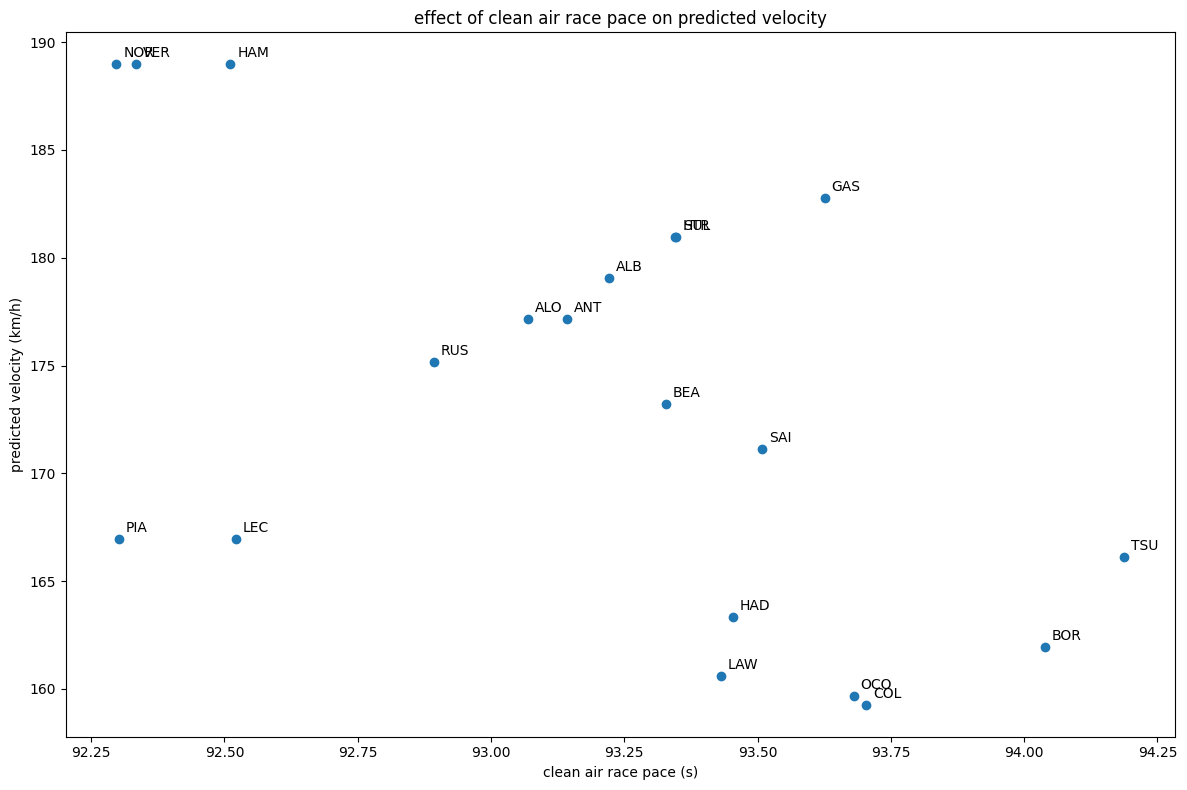

In [78]:
# plot effect of clean air race pace
plt.figure(figsize=(12, 8))
plt.scatter(final_results["CleanAirRacePace (s)"], final_results["PredictedVelocity (km/h)"])
for i, driver in enumerate(final_results["Driver"]):
    plt.annotate(driver, (final_results["CleanAirRacePace (s)"].iloc[i], final_results["PredictedVelocity (km/h)"].iloc[i]),
                    xytext=(5, 5), textcoords='offset points')
plt.xlabel("clean air race pace (s)")
plt.ylabel("predicted velocity (km/h)")
plt.title("effect of clean air race pace on predicted velocity")
plt.tight_layout()
plt.show()

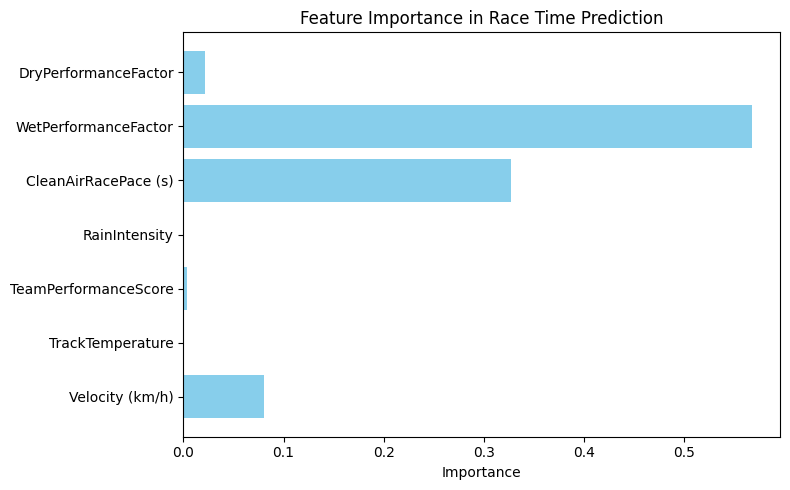

In [79]:
# Plot feature importances
feature_importance = model.feature_importances_
features = X.columns

plt.figure(figsize=(8,5))
plt.barh(features, feature_importance, color='skyblue')
plt.xlabel("Importance")
plt.title("Feature Importance in Race Time Prediction")
plt.tight_layout()
plt.show()


In [80]:
# sort results and get top 3
final_results = merged.sort_values("PredictedVelocity (km/h)", ascending=False).reset_index(drop=True)
podium = final_results.loc[:2, ["Driver", "PredictedVelocity (km/h)"]]

print("\n🏆 Predicted in the Top 3 🏆")
print(f"🥇 P1: {podium.iloc[0]['Driver']}")
print(f"🥈 P2: {podium.iloc[1]['Driver']}")
print(f"🥉 P3: {podium.iloc[2]['Driver']}")


🏆 Predicted in the Top 3 🏆
🥇 P1: NOR
🥈 P2: HAM
🥉 P3: VER
